In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from tips.io import load_ds

tunit = 1/100.
eunit = 1.0
natom = 640
skip = 200

def plot_energies(ax, ds, init, color):
    e_avg = np.array([d['energy'] for d in ds])/640
    t = np.arange(len(e_avg))*tunit
    l2, = ax.plot(t, e_avg, color=color, lw=1, alpha=0.2)
    
    try:
        e_bias = np.array([d['energy_bias'] for d in ds])/640
        e_std = np.array([d['energy_std'] for d in ds])/640
        l1 = ax.fill_between(t, e_avg-e_std, e_avg+e_std, color=color, alpha=0.5)
        return (l1,l2)
        return l2
    except:
        return l2

def doplots():
    l1, l2 = None, None
    for ftraj in glob(f'../{name}/emd/gen{gen}/*r1.08/asemd.traj'):
        init = Path(ftraj).parent.name
        traj = load_ds(ftraj, fmt='asetraj', index=f'::{skip}')
        l1 = plot_energies(ax1, traj, init, 'tab:green')
        
        try:
            idx = np.loadtxt(f'../{name}/merge/gen{gen}/{init}/merged.idx')//skip
            sort = np.argsort(idx)
            e_model = np.array([traj[int(i)]['energy'] for i in idx]) / natom
            f_model = np.array([traj[int(i)]['force'] for i in idx])
            
            label = load_ds(f'../{name}/merge/gen{gen}/{init}/merged.traj', fmt='asetraj')
            e_label = np.array([l['energy'] for l in label]) * eunit / natom
            f_label = np.array([l['force'] for l in label]) * eunit
            print(f"{name}/gen{gen}/{init:14s}",
                  f"e_rmse: {np.sqrt(np.mean((e_model-e_label)**2))*1000:5.2f} meV/a, ",
                  f"f_rmse: {np.sqrt(np.mean((f_model-f_label)**2))*1000:5.2f} meV/Å, ",
                  f"e_maxerr: {np.max(np.abs(e_model-e_label)):5.3f}, ",
                  f"f_maxerr: {np.max(np.abs(f_model-f_label)):5.3f}",
                 )
            l2, = ax1.plot(idx[sort]*tunit, e_label[sort], '--x', ms=2, lw=1, color='tab:red')
            ax2.scatter(e_model, e_label, color='tab:red', s=5,ec=None)
            emin, emax = -125.2, -125.14
            ax2.plot([emin, emax], [emin, emax], ':', lw=1, color='gray')
            ax1.set_ylim(emin, emax)
            ax2.set_ylim(emin, emax)
            ax2.set_xlim(emin, emax)
            fmin, fmax = -10,10
            ax3.scatter(f_model, f_label, color='tab:red', s=2, alpha=0.5,ec=None)
            ax3.plot([fmin, fmax], [fmin, fmax], ':', lw=1, color='gray')
            ax3.set_xlim(fmin, fmax)
            ax3.set_ylim(fmin, fmax)
        except:
            pass
    
    ax1.set_xlabel('time [ps]')
    ax1.set_title(title, fontsize=10)
    ax2.set_xlabel('$E_{pred}~[eV/atom]$')
    ax3.set_xlabel('$F_{pred}~[eV/\AA]$')
    return l1, l2


exp/transfer/gen36/m32i0-r1.08    e_rmse:  0.64 meV/a,  f_rmse: 115.72 meV/Å,  e_maxerr: 0.002,  f_maxerr: 0.783
exp/transfer/gen36/m16i16-r1.08   e_rmse:  1.62 meV/a,  f_rmse: 155.87 meV/Å,  e_maxerr: 0.004,  f_maxerr: 7.200
exp/transfer/gen36/m0i32-r1.08    e_rmse:  1.14 meV/a,  f_rmse: 119.03 meV/Å,  e_maxerr: 0.002,  f_maxerr: 1.229


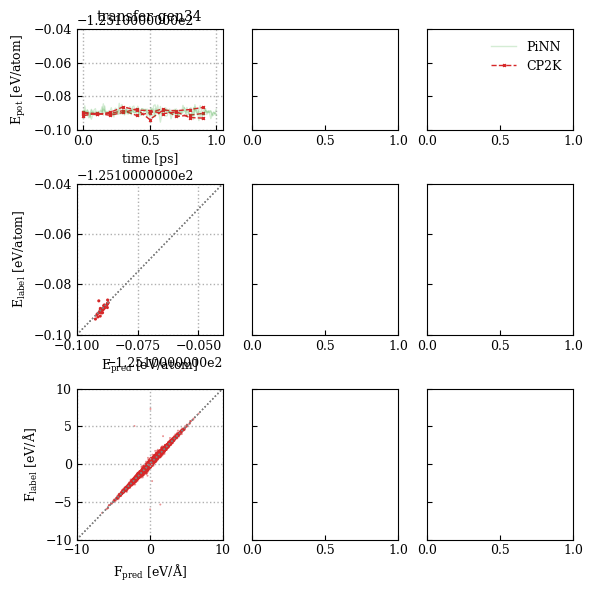

In [24]:
f, axs = plt.subplots(3,3, figsize=[6,6], sharey='row', gridspec_kw={'height_ratios': [2,3,3]})
for (name, gen, title), (ax1, ax2, ax3) in zip([
   #['exp/transfer',20, 'transfer-gen20'],
   #['exp/transfer',25, 'transfer-gen25'],
   ['exp/transfer',36, 'transfer-gen34'],
], axs.T):
    l1, l2 = doplots()
    ax1.grid(lw=1, ls=':', which='both')
    ax2.grid(lw=1, ls=':', which='both')
    ax3.grid(lw=1, ls=':', which='both')
    
axs[0,-1].legend([l1,l2], ['PiNN', 'CP2K'],facecolor='w',frameon=True,edgecolor='none')
axs[0,0].set_ylabel('$E_{pot}~[eV/atom]$')
axs[1,0].set_ylabel('$E_{label}~[eV/atom]$')
axs[2,0].set_ylabel('$F_{label}~[eV/\AA]$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)